# EAS 503 PYTHON PROJECT- CO2 EMISSIONS CLASSIFICATION

In [3]:
import pandas as pd
import sqlite3


# Load the uploaded CSV file
file_path = '/Users/Varshini/Python_project/co2.csv'
df = pd.read_csv(file_path)

df.head()


,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


In [61]:
max(df['CO2 Emissions(g/km)'])

5.948034989180646

In [4]:

# Step 1: Create Manufacturer table
manufacturer = df[['Make']].drop_duplicates().reset_index(drop=True)
manufacturer['Make_ID'] = manufacturer.index + 1  # Create a unique ID
print("Manufacturer Table:\n", manufacturer)

# Step 2: Create Vehicle table
vehicle = df[['Model', 'Make', 'Vehicle Class']].drop_duplicates().reset_index(drop=True)
vehicle = vehicle.merge(manufacturer, on='Make', how='left')  # Add Make_ID as a foreign key
vehicle['Model_ID'] = vehicle.index + 1  # Create a unique ID
print("Vehicle Table:\n", vehicle)

# Step 3: Create Engine and Transmission table
engine_trans = df[['Model', 'Engine Size(L)', 'Cylinders', 'Transmission']].drop_duplicates().reset_index(drop=True)
engine_trans = engine_trans.merge(vehicle[['Model', 'Model_ID']], on='Model', how='left')  # Add Model_ID
engine_trans['Engine_ID'] = engine_trans.index + 1  # Create a unique ID
print("Engine and Transmission Table:\n", engine_trans)

# Step 4: Create Fuel and Emissions table
fuel_emissions = df[[
    'Model', 'Transmission', 'Fuel Type',
    'Fuel Consumption City (L/100 km)', 'Fuel Consumption Hwy (L/100 km)',
    'Fuel Consumption Comb (L/100 km)', 'Fuel Consumption Comb (mpg)', 'CO2 Emissions(g/km)'
]].drop_duplicates().reset_index(drop=True)
fuel_emissions = fuel_emissions.merge(engine_trans[['Model', 'Transmission', 'Engine_ID']], on=['Model', 'Transmission'], how='left')
fuel_emissions['Fuel_ID'] = fuel_emissions.index + 1  # Create a unique ID
print("Fuel and Emissions Table:\n", fuel_emissions)

# Step 5: Save the normalized tables into a SQLite database
conn = sqlite3.connect('/Users/prakashreddypasham/Desktop/Varshini/Python_project/vehicle_co2_normalized.db')

# Save each table
manufacturer[['Make_ID', 'Make']].to_sql('Manufacturer', conn, if_exists='replace', index=False)
vehicle[['Model_ID', 'Model', 'Make_ID', 'Vehicle Class']].to_sql('Vehicle', conn, if_exists='replace', index=False)
engine_trans[['Engine_ID', 'Model_ID', 'Engine Size(L)', 'Cylinders', 'Transmission']].to_sql('Engine_Transmission', conn, if_exists='replace', index=False)
fuel_emissions[['Fuel_ID', 'Engine_ID', 'Fuel Type', 'Fuel Consumption City (L/100 km)', 'Fuel Consumption Hwy (L/100 km)',
                'Fuel Consumption Comb (L/100 km)', 'Fuel Consumption Comb (mpg)', 'CO2 Emissions(g/km)']].to_sql('Fuel_Emissions', conn, if_exists='replace', index=False)

print("Tables successfully normalized and saved.")


Manufacturer Table:
              Make  Make_ID
0           ACURA        1
1      ALFA ROMEO        2
2    ASTON MARTIN        3
3            AUDI        4
4         BENTLEY        5
5             BMW        6
6           BUICK        7
7        CADILLAC        8
8       CHEVROLET        9
9        CHRYSLER       10
10          DODGE       11
11           FIAT       12
12           FORD       13
13            GMC       14
14          HONDA       15
15        HYUNDAI       16
16       INFINITI       17
17         JAGUAR       18
18           JEEP       19
19            KIA       20
20    LAMBORGHINI       21
21     LAND ROVER       22
22          LEXUS       23
23        LINCOLN       24
24       MASERATI       25
25          MAZDA       26
26  MERCEDES-BENZ       27
27           MINI       28
28     MITSUBISHI       29
29         NISSAN       30
30        PORSCHE       31
31            RAM       32
32    ROLLS-ROYCE       33
33          SCION       34
34          SMART       35
35     

In [5]:

# Connect to the SQLite database
conn = sqlite3.connect('/Users/prakashreddypasham/Desktop/Varshini/Python_project/vehicle_co2_normalized.db')

# Function to execute and print SQL queries
def execute_query(query, description):
    print(f"\n{description}")
    result = pd.read_sql_query(query, conn)
    print(result.head())  # Display first few rows of the result

# Query 1: List all manufacturers
query1 = """
SELECT * FROM Manufacturer;
"""
execute_query(query1, "List of Manufacturers")




List of Manufacturers
   Make_ID          Make
0        1         ACURA
1        2    ALFA ROMEO
2        3  ASTON MARTIN
3        4          AUDI
4        5       BENTLEY


In [6]:


# SQL query to join all tables
query = """
SELECT 
    m.Make AS Manufacturer,
    v.Model AS Vehicle_Model,
    v.[Vehicle Class] AS Vehicle_Class,
    et.[Engine Size(L)] AS Engine_Size,
    et.Cylinders,
    et.Transmission,
    f.[Fuel Type] AS Fuel_Type,
    f.[Fuel Consumption City (L/100 km)] AS Fuel_Consumption_City,
    f.[Fuel Consumption Hwy (L/100 km)] AS Fuel_Consumption_Hwy,
    f.[Fuel Consumption Comb (L/100 km)] AS Fuel_Consumption_Comb_L_per_100_km,
    f.[Fuel Consumption Comb (mpg)] AS Fuel_Consumption_Comb_mpg,
    f.[CO2 Emissions(g/km)] AS CO2_Emissions
FROM 
    Manufacturer m
JOIN 
    Vehicle v ON m.Make_ID = v.Make_ID
JOIN 
    Engine_Transmission et ON v.Model_ID = et.Model_ID
JOIN 
    Fuel_Emissions f ON et.Engine_ID = f.Engine_ID;
"""

# Execute the query and load the result into a DataFrame
data = pd.read_sql_query(query, conn)

# Display the first few rows of the combined data
print(data.head())

# Close the database connection
conn.close()


  Manufacturer Vehicle_Model Vehicle_Class  Engine_Size  Cylinders  \
0        ACURA           ILX       COMPACT          2.0          4   
1        ACURA           ILX       COMPACT          2.0          4   
2        ACURA           ILX       COMPACT          2.4          4   
3        ACURA           ILX       COMPACT          2.4          4   
4        ACURA           ILX       COMPACT          2.4          4   

  Transmission Fuel_Type  Fuel_Consumption_City  Fuel_Consumption_Hwy  \
0          AS5         Z                    9.7                   6.7   
1          AS5         Z                    9.9                   6.7   
2           M6         Z                   10.8                   7.4   
3           M6         Z                   11.2                   7.7   
4          AM8         Z                    9.3                   6.6   

   Fuel_Consumption_Comb_L_per_100_km  Fuel_Consumption_Comb_mpg  \
0                                 8.3                         34   
1   

In [7]:
data.head()


,Manufacturer,Vehicle_Model,Vehicle_Class,Engine_Size,Cylinders,Transmission,Fuel_Type,Fuel_Consumption_City,Fuel_Consumption_Hwy,Fuel_Consumption_Comb_L_per_100_km,Fuel_Consumption_Comb_mpg,CO2_Emissions
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.7,6.7,8.3,34,191
1,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
2,ACURA,ILX,COMPACT,2.4,4,M6,Z,10.8,7.4,9.3,30,214
3,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
4,ACURA,ILX,COMPACT,2.4,4,AM8,Z,9.3,6.6,8.1,35,189


In [8]:
from sklearn.model_selection import train_test_split

# Data exploration
print(df.describe())
print(df.info())
print(df.isnull().sum())
# Identify classes with fewer than 2 samples
class_counts = df['Fuel Type'].value_counts()
valid_classes = class_counts[class_counts >= 2].index

# Filter the dataset
df_filtered = df[df['Fuel Type'].isin(valid_classes)]

# Proceed with train/test split
X = df_filtered.drop(columns=['CO2 Emissions(g/km)'])
y = df_filtered['CO2 Emissions(g/km)']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=df_filtered['Fuel Type'], random_state=42
)

print("Train/Test Split Completed")


       Engine Size(L)    Cylinders  Fuel Consumption City (L/100 km)  \
count     7385.000000  7385.000000                       7385.000000   
mean         3.160068     5.615030                         12.556534   
std          1.354170     1.828307                          3.500274   
min          0.900000     3.000000                          4.200000   
25%          2.000000     4.000000                         10.100000   
50%          3.000000     6.000000                         12.100000   
75%          3.700000     6.000000                         14.600000   
max          8.400000    16.000000                         30.600000   

       Fuel Consumption Hwy (L/100 km)  Fuel Consumption Comb (L/100 km)  \
count                      7385.000000                       7385.000000   
mean                          9.041706                         10.975071   
std                           2.224456                          2.892506   
min                           4.000000         

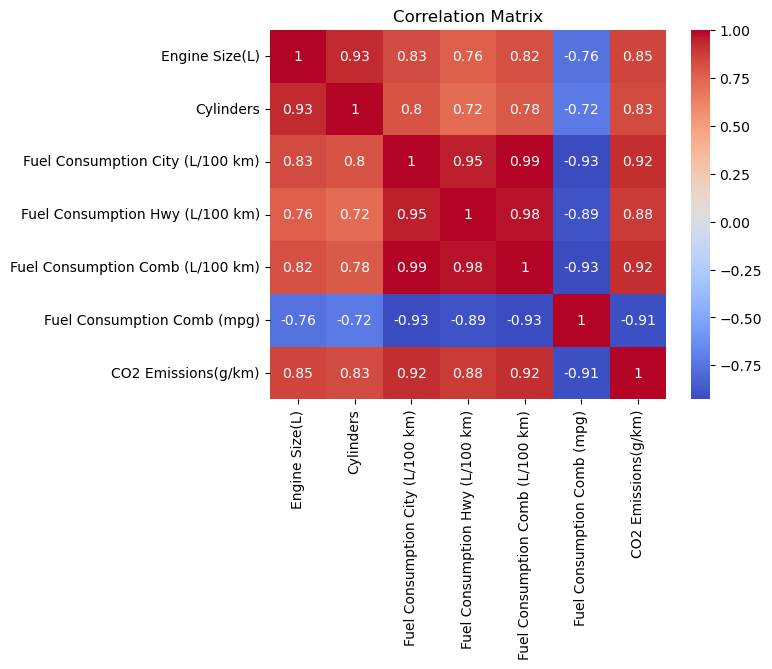

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
# Select numeric columns
numeric_df = df.select_dtypes(include='number')

# Correlation matrix
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()



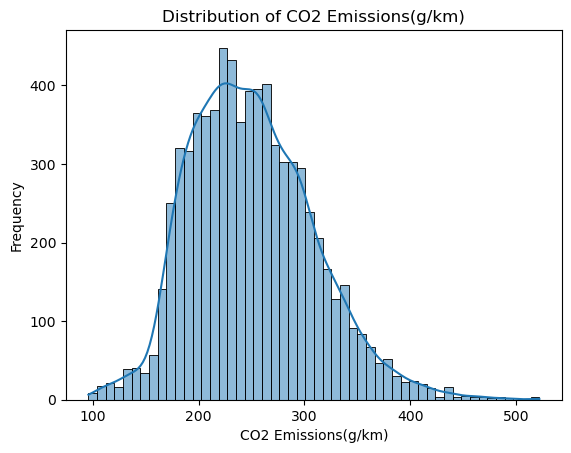

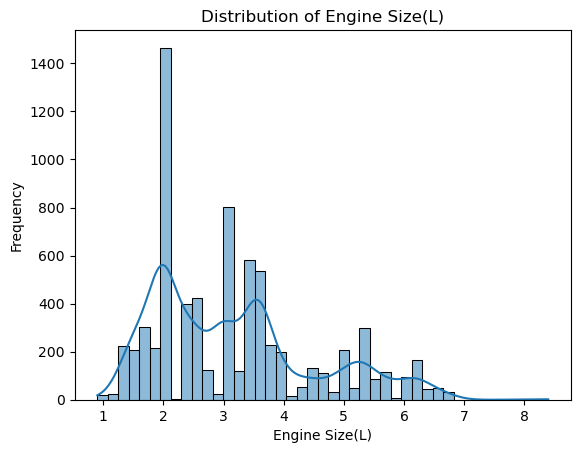

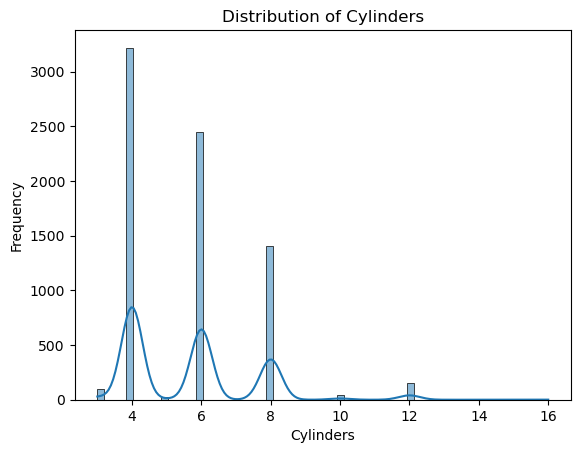

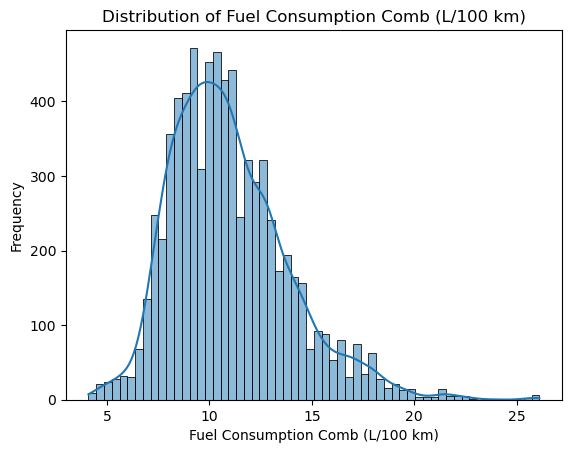

In [10]:
columns_to_plot = ['CO2 Emissions(g/km)', 'Engine Size(L)', 'Cylinders', 
                   'Fuel Consumption Comb (L/100 km)']
for col in columns_to_plot:
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()
    

In [13]:
# Count missing values per column
missing_counts = df.isnull().sum()
print("\nMissing Values:\n", missing_counts)


Missing Values:
 Make                                0
Model                               0
Vehicle Class                       0
Engine Size(L)                      0
Cylinders                           0
Transmission                        0
Fuel Type                           0
Fuel Consumption City (L/100 km)    0
Fuel Consumption Hwy (L/100 km)     0
Fuel Consumption Comb (L/100 km)    0
Fuel Consumption Comb (mpg)         0
CO2 Emissions(g/km)                 0
dtype: int64


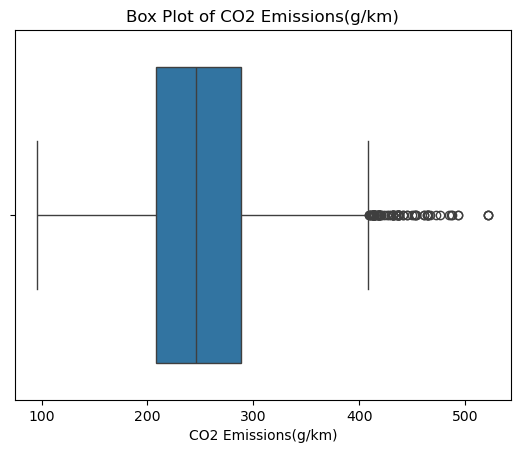

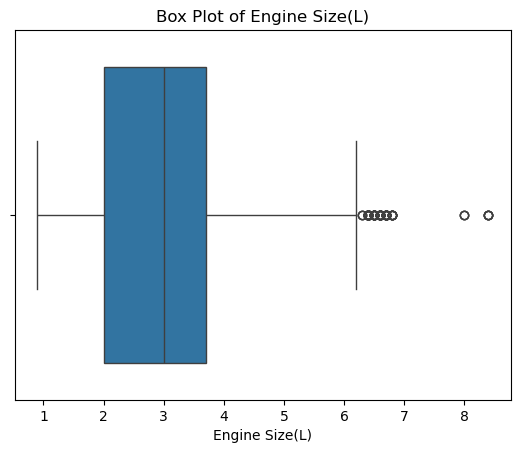

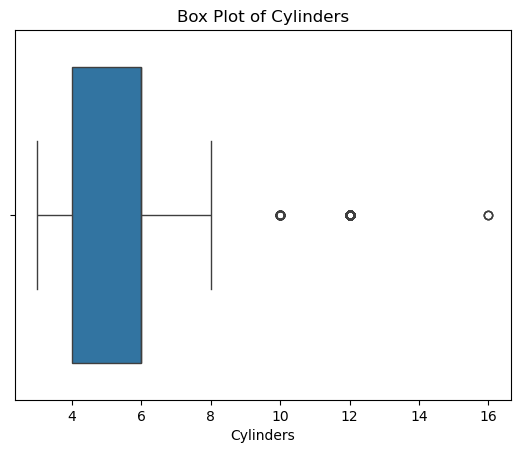

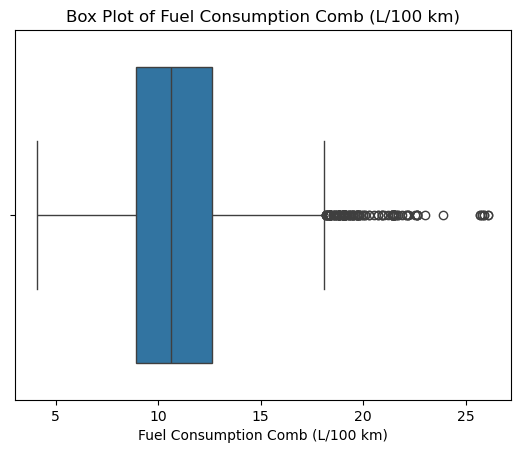

In [11]:
for col in columns_to_plot:
    sns.boxplot(x=df[col])
    plt.title(f"Box Plot of {col}")
    plt.xlabel(col)
    plt.show()

In [14]:
def remove_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# Apply removal to numeric columns
for col in numeric_df:
    df = remove_outliers(df, col)

print("Outliers removed.")

Outliers removed.


In [15]:
# Log transform to handle skewness and outliers
import numpy as np
for col in numeric_df:
    df[col] = np.log1p(df[col])  # log1p handles zero values as log(1 + x)

print("Outliers handled using log transformation.")

Outliers handled using log transformation.


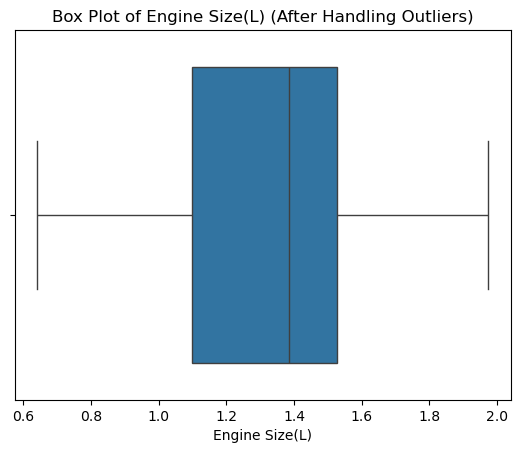

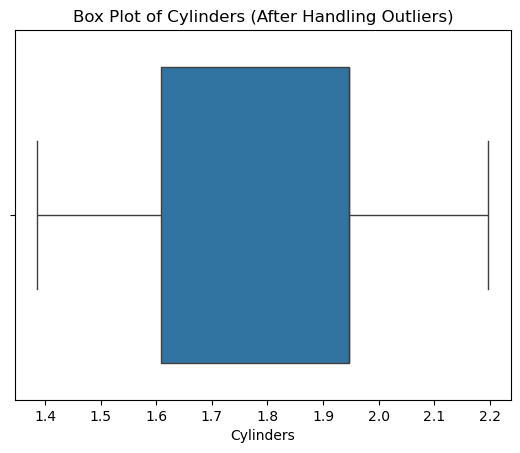

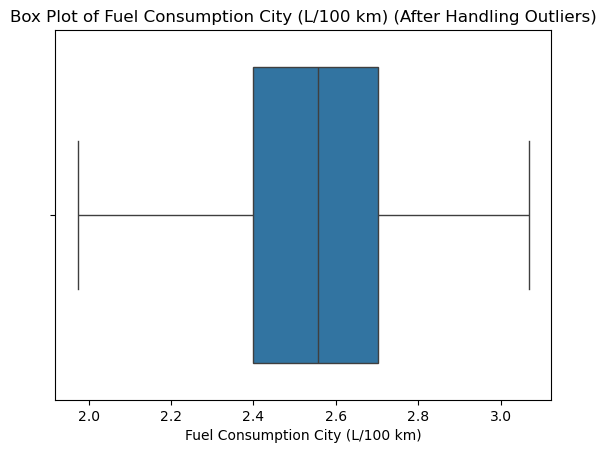

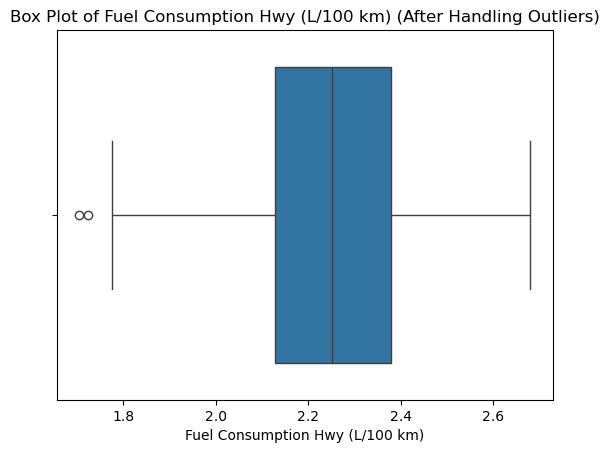

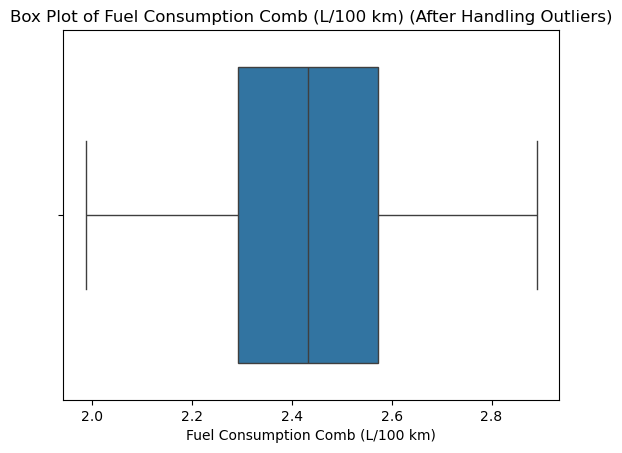

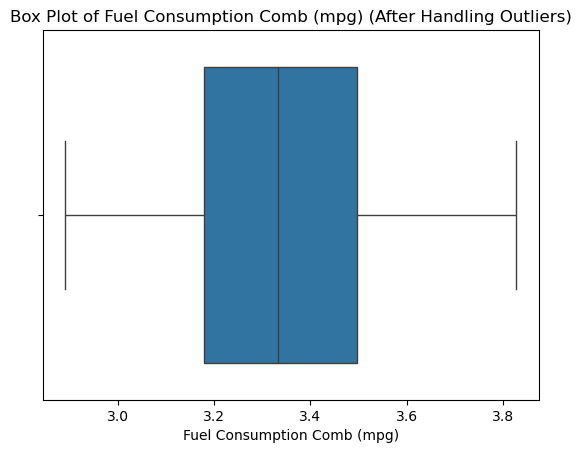

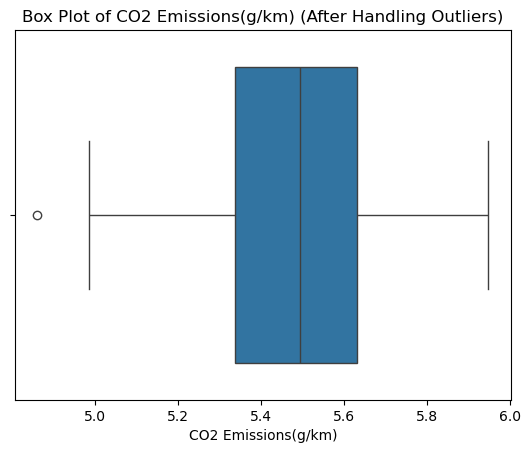

       Engine Size(L)    Cylinders  Fuel Consumption City (L/100 km)  \
count     6697.000000  6697.000000                       6697.000000   
mean         1.341304     1.823951                          2.550626   
std          0.285756     0.228103                          0.202149   
min          0.641854     1.386294                          1.974081   
25%          1.098612     1.609438                          2.397895   
50%          1.386294     1.945910                          2.557227   
75%          1.526056     1.945910                          2.701361   
max          1.974081     2.197225                          3.068053   

       Fuel Consumption Hwy (L/100 km)  Fuel Consumption Comb (L/100 km)  \
count                      6697.000000                       6697.000000   
mean                          2.259915                          2.430812   
std                           0.172604                          0.187852   
min                           1.704748         

In [16]:
# Replot box plots
for col in numeric_df:
    sns.boxplot(x=df[col])
    plt.title(f"Box Plot of {col} (After Handling Outliers)")
    plt.xlabel(col)
    plt.show()

# Check summary statistics
print(df.describe())


Max Values of Important Features:
Engine Size(L)                       8.4
Cylinders                           16.0
Fuel Consumption Comb (L/100 km)    26.1
dtype: float64


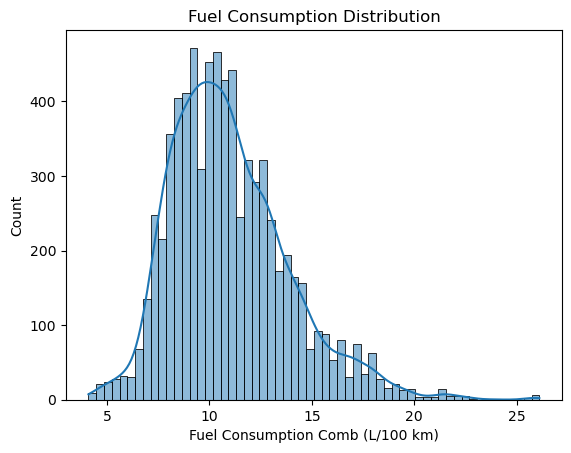

In [12]:
# Check for capped values
print("Max Values of Important Features:")
print(df[['Engine Size(L)', 'Cylinders', 'Fuel Consumption Comb (L/100 km)']].max())

# Check distribution to spot abrupt cut-offs
sns.histplot(df['Fuel Consumption Comb (L/100 km)'], kde=True)
plt.title("Fuel Consumption Distribution")
plt.show()

# Experiment 1

Initialized MLflow to track repo "varshinivatnala56/my-first-repo"

Repository varshinivatnala56/my-first-repo initialized!

Checking NaN values: Make                                0
Model                               0
Vehicle Class                       0
Engine Size(L)                      0
Cylinders                           0
Transmission                        0
Fuel Type                           0
Fuel Consumption City (L/100 km)    0
Fuel Consumption Hwy (L/100 km)     0
Fuel Consumption Comb (L/100 km)    0
Fuel Consumption Comb (mpg)         0
dtype: int64


2024/12/21 13:18:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run youthful-conch-7 at: https://dagshub.com/varshinivatnala56/my-first-repo.mlflow/#/experiments/0/runs/62251195b053433c817d4023b937c768
🧪 View experiment at: https://dagshub.com/varshinivatnala56/my-first-repo.mlflow/#/experiments/0
Experiment completed and logged to MLflow.


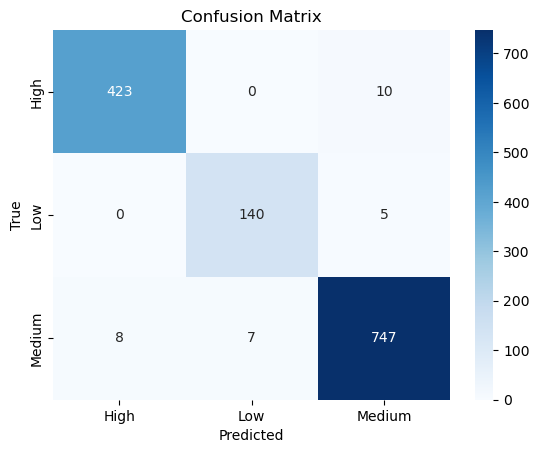

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, LabelEncoder , MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns


import dagshub
dagshub.init(repo_owner='varshinivatnala56', repo_name='my-first-repo', mlflow=True)

# Feature and target selection
# Ensure CO2 Emissions(g/km) is numeric and clean
y = pd.cut(df['CO2 Emissions(g/km)'], bins=3, labels=["Low", "Medium", "High"])
X = df.drop(columns=['CO2 Emissions(g/km)'])

# Encode target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define preprocessing steps
numeric_features = ['Engine Size(L)', 'Cylinders', 'Fuel Consumption Comb (L/100 km)']
categorical_features = ['Vehicle Class', 'Fuel Type', 'Transmission']

numeric_transformer = Pipeline(steps=[
    ('log', FunctionTransformer(np.log1p)),  # Log Transformation
    ('scaler', StandardScaler()),           # Standard Scaler
    ('minmax', MinMaxScaler())              # MinMax Scaler
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-Hot Encoding
])

# Combine preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Define pipeline with Logistic Regression
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, tol=1e-3, solver='lbfgs'))
])

# Cross-validation and parameter tuning
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['liblinear', 'saga'],
    'classifier__penalty': ['l2', 'l1']  # Required for "saga" solver
}
grid_search = GridSearchCV(model, param_grid, cv=10, scoring='f1_macro', return_train_score=True)

# Logging with MLflow
mlflow.set_tracking_uri("https://dagshub.com/varshinivatnala56/my-first-repo.mlflow")
mlflow.set_experiment("CO2_Emissions_Logistic_Regression")

with mlflow.start_run():
    # Check and log NaN summary
    nan_summary = X_train.isnull().sum()
    print("Checking NaN values:", nan_summary)

    # Impute missing values or handle them in preprocessing (optional)
    
    # Train model
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # Log parameters and metrics
    mlflow.log_params(grid_search.best_params_)
    mlflow.log_metric("cv_mean_score", grid_search.best_score_)

    # Evaluate on test set
    y_pred = best_model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='macro')
    cm = confusion_matrix(y_test, y_pred)

    mlflow.log_metric("test_f1", f1)
    mlflow.sklearn.log_model(best_model, "logistic_regression_model")

    # Plot confusion matrix
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_encoder.classes_, 
                yticklabels=label_encoder.classes_)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

print("Experiment completed and logged to MLflow.")


In [59]:
df.head()

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,ACURA,ILX,COMPACT,1.098612,1.609438,AS5,Z,2.388763,2.041220,2.251292,3.526361,5.283204
1,ACURA,ILX,COMPACT,1.223775,1.609438,M6,Z,2.501436,2.163323,2.360854,3.401197,5.402677
3,ACURA,MDX 4WD,SUV - SMALL,1.504077,1.945910,AS6,Z,2.617396,2.312535,2.493205,3.258097,5.545177
4,ACURA,RDX AWD,SUV - SMALL,1.504077,1.945910,AS6,Z,2.572612,2.272126,2.451005,3.332205,5.501258
5,ACURA,RLX,MID-SIZE,1.504077,1.945910,AS6,Z,2.557227,2.163323,2.397895,3.367296,5.442418


# Experiment 2

2024/12/21 13:27:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression at: https://dagshub.com/varshinivatnala56/my-first-repo.mlflow/#/experiments/1/runs/6c2ab776ee2b46bcada4a5c8d01ac0fb
🧪 View experiment at: https://dagshub.com/varshinivatnala56/my-first-repo.mlflow/#/experiments/1
Experiment for LogisticRegression completed and logged to MLflow.


2024/12/21 13:27:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RidgeClassifier at: https://dagshub.com/varshinivatnala56/my-first-repo.mlflow/#/experiments/1/runs/0627678a8e3f47de8a2324c0898c7fe5
🧪 View experiment at: https://dagshub.com/varshinivatnala56/my-first-repo.mlflow/#/experiments/1
Experiment for RidgeClassifier completed and logged to MLflow.


2024/12/21 13:28:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier at: https://dagshub.com/varshinivatnala56/my-first-repo.mlflow/#/experiments/1/runs/ae51f4b70cfa44dab2453436ef2e59d0
🧪 View experiment at: https://dagshub.com/varshinivatnala56/my-first-repo.mlflow/#/experiments/1
Experiment for RandomForestClassifier completed and logged to MLflow.


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:28:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:28:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:28:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:28:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

🏃 View run XGBClassifier at: https://dagshub.com/varshinivatnala56/my-first-repo.mlflow/#/experiments/1/runs/75a594bec16749239563b0509e896cd3
🧪 View experiment at: https://dagshub.com/varshinivatnala56/my-first-repo.mlflow/#/experiments/1
Experiment for XGBClassifier completed and logged to MLflow.


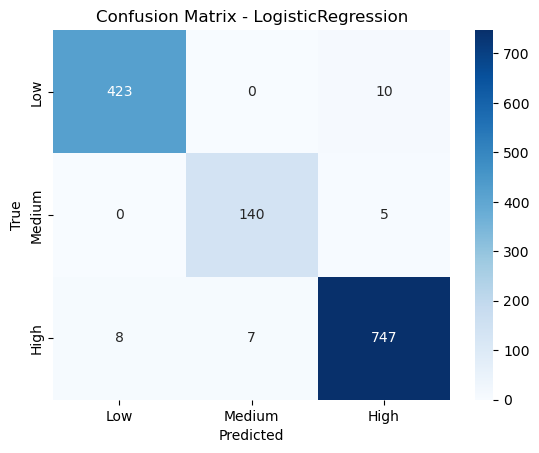

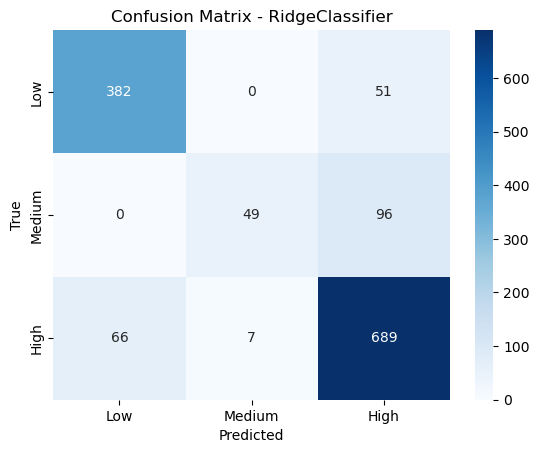

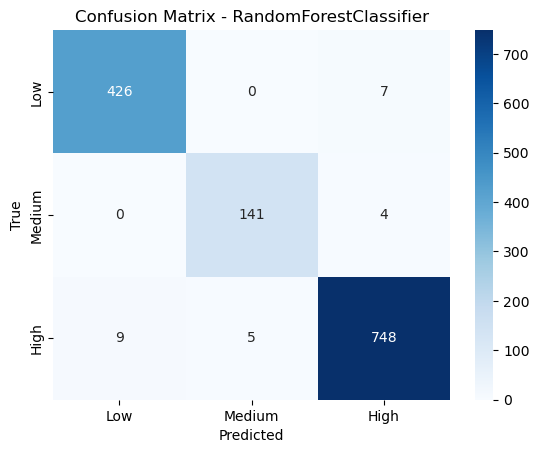

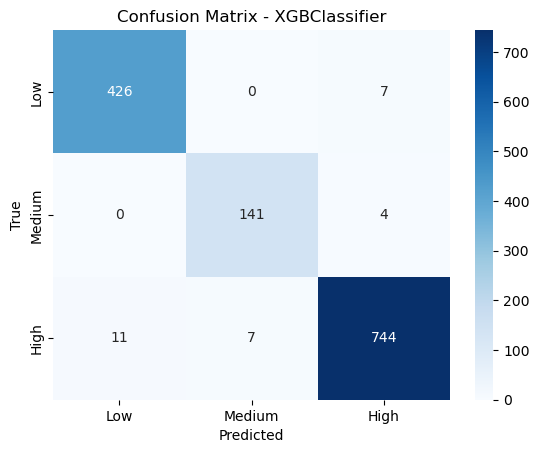

In [30]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Define classifiers
classifiers = {
    'LogisticRegression': LogisticRegression(max_iter=1000, tol=1e-3, solver='lbfgs'),
    'RidgeClassifier': RidgeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'XGBClassifier': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

# Logging with MLflow
mlflow.set_tracking_uri("https://dagshub.com/varshinivatnala56/my-first-repo.mlflow")
mlflow.set_experiment("CO2_Emissions_Classification")

for classifier_name, classifier in classifiers.items():
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    param_grid = {}
    if classifier_name == 'LogisticRegression':
        param_grid = {
            'classifier__C': [0.01, 0.1, 1, 10, 100],
            'classifier__solver': ['liblinear', 'saga'],
            'classifier__penalty': ['l2', 'l1']
        }
    elif classifier_name == 'RandomForestClassifier':
        param_grid = {
            'classifier__n_estimators': [50, 100, 200],
            'classifier__max_depth': [None, 10, 20]
        }
    elif classifier_name == 'XGBClassifier':
        param_grid = {
            'classifier__n_estimators': [50, 100, 200],
            'classifier__max_depth': [3, 6, 10],
            'classifier__learning_rate': [0.01, 0.1, 0.2]
        }

    grid_search = GridSearchCV(model, param_grid, cv=10, scoring='f1_macro', return_train_score=True)

    with mlflow.start_run(run_name=classifier_name):
        # Train model
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_

        # Log parameters and metrics
        mlflow.log_params(grid_search.best_params_)
        mlflow.log_metric("cv_mean_score", grid_search.best_score_)

        # Evaluate on test set
        y_pred = best_model.predict(X_test)
        f1 = f1_score(y_test, y_pred, average='macro')
        cm = confusion_matrix(y_test, y_pred)

        mlflow.log_metric("test_f1", f1)
        mlflow.sklearn.log_model(best_model, f"{classifier_name}_model")

        # Plot confusion matrix
        fig, ax = plt.subplots()
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=["Low", "Medium", "High"], 
                    yticklabels=["Low", "Medium", "High"])
        plt.title(f"Confusion Matrix - {classifier_name}")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        confusion_matrix_path = f"confusion_matrix_{classifier_name}.png"
        plt.savefig(confusion_matrix_path)
        mlflow.log_artifact(confusion_matrix_path)

    print(f"Experiment for {classifier_name} completed and logged to MLflow.")


# Experiment 3

2024/12/21 13:32:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression at: https://dagshub.com/varshinivatnala56/my-first-repo.mlflow/#/experiments/2/runs/59b16d1851dd4c2c803192e9d7d9b5eb
🧪 View experiment at: https://dagshub.com/varshinivatnala56/my-first-repo.mlflow/#/experiments/2
Experiment for LogisticRegression completed and logged to MLflow.


2024/12/21 13:32:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RidgeClassifier at: https://dagshub.com/varshinivatnala56/my-first-repo.mlflow/#/experiments/2/runs/9b67eefc054d48baa06d7d99c55fe5b5
🧪 View experiment at: https://dagshub.com/varshinivatnala56/my-first-repo.mlflow/#/experiments/2
Experiment for RidgeClassifier completed and logged to MLflow.


2024/12/21 13:33:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier at: https://dagshub.com/varshinivatnala56/my-first-repo.mlflow/#/experiments/2/runs/ab2082647d8a42ffbd9b1e7e5f61055c
🧪 View experiment at: https://dagshub.com/varshinivatnala56/my-first-repo.mlflow/#/experiments/2
Experiment for RandomForestClassifier completed and logged to MLflow.


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:33:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:33:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:33:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:33:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

🏃 View run XGBClassifier at: https://dagshub.com/varshinivatnala56/my-first-repo.mlflow/#/experiments/2/runs/8bd85aa131c24200a059f05678f481ca
🧪 View experiment at: https://dagshub.com/varshinivatnala56/my-first-repo.mlflow/#/experiments/2
Experiment for XGBClassifier completed and logged to MLflow.


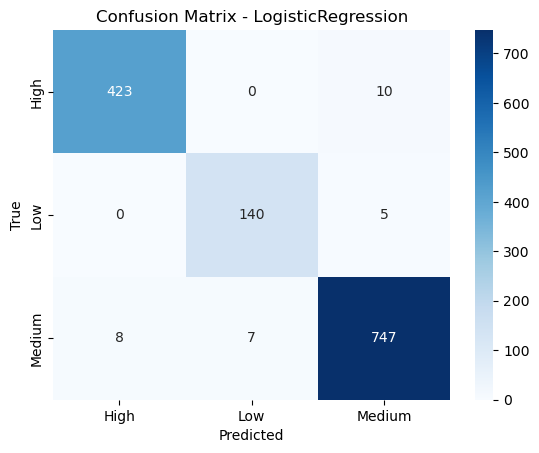

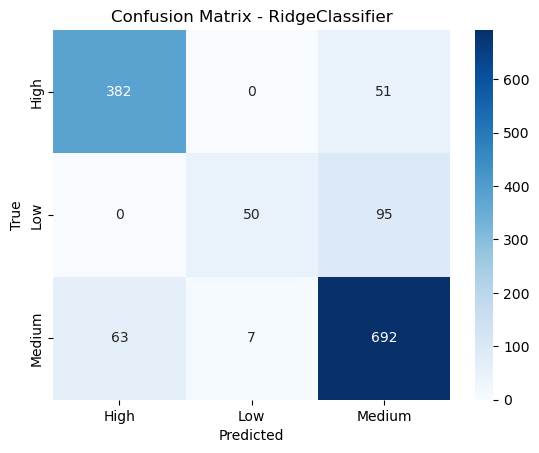

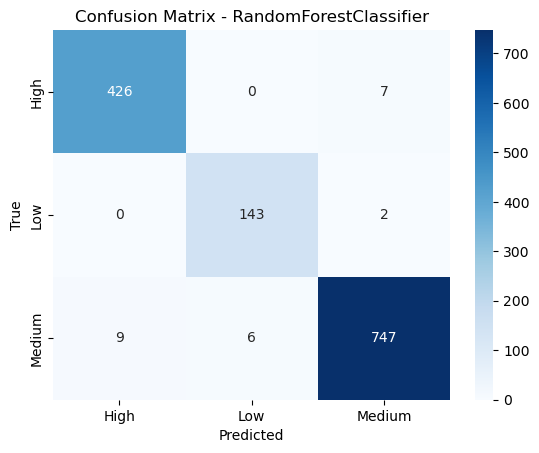

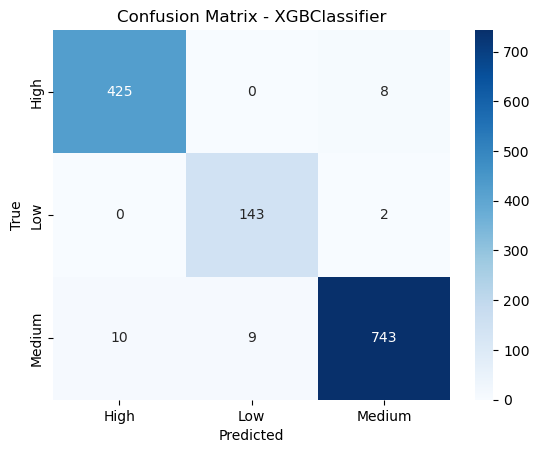

In [31]:


# Feature and target selection
label_encoder = LabelEncoder()
y = pd.cut(df['CO2 Emissions(g/km)'], bins=3, labels=["Low", "Medium", "High"])
y = label_encoder.fit_transform(y)

# Feature engineering and attribute combination
X = df.drop(columns=['CO2 Emissions(g/km)'])
X['Engine_Cylinders_Ratio'] = X['Engine Size(L)'] / (X['Cylinders'] + 1)
X['Fuel_Consumption_per_Cylinder'] = X['Fuel Consumption Comb (L/100 km)'] / (X['Cylinders'] + 1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define preprocessing steps
numeric_features = ['Engine Size(L)', 'Cylinders', 'Fuel Consumption Comb (L/100 km)',
                     'Engine_Cylinders_Ratio', 'Fuel_Consumption_per_Cylinder']
categorical_features = ['Vehicle Class', 'Fuel Type', 'Transmission']

numeric_transformer = Pipeline(steps=[
    ('log', FunctionTransformer(np.log1p, validate=True)),  # Log Transformation
    ('scaler', StandardScaler()),           # Standard Scaler
    ('minmax', MinMaxScaler())              # MinMax Scaler
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-Hot Encoding
])

# Combine preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Define classifiers
classifiers = {
    'LogisticRegression': LogisticRegression(max_iter=1000, tol=1e-3, solver='lbfgs'),
    'RidgeClassifier': RidgeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'XGBClassifier': XGBClassifier(use_label_encoder=True, eval_metric='mlogloss', random_state=42)
}

# Logging with MLflow
mlflow.set_tracking_uri("https://dagshub.com/varshinivatnala56/my-first-repo.mlflow")
mlflow.set_experiment("CO2_Emissions_Classification_Feature_Engineering")

for classifier_name, classifier in classifiers.items():
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    param_grid = {}
    if classifier_name == 'LogisticRegression':
        param_grid = {
            'classifier__C': [0.01, 0.1, 1, 10, 100],
            'classifier__solver': ['liblinear', 'saga'],
            'classifier__penalty': ['l2', 'l1']
        }
    elif classifier_name == 'RandomForestClassifier':
        param_grid = {
            'classifier__n_estimators': [50, 100, 200],
            'classifier__max_depth': [None, 10, 20]
        }
    elif classifier_name == 'XGBClassifier':
        param_grid = {
            'classifier__n_estimators': [50, 100, 200],
            'classifier__max_depth': [3, 6, 10],
            'classifier__learning_rate': [0.01, 0.1, 0.2]
        }

    grid_search = GridSearchCV(model, param_grid, cv=10, scoring='f1_macro', return_train_score=True)

    with mlflow.start_run(run_name=classifier_name):
        # Train model
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_

        # Log parameters and metrics
        mlflow.log_params(grid_search.best_params_)
        mlflow.log_metric("cv_mean_score", grid_search.best_score_)

        # Evaluate on test set
        y_pred = best_model.predict(X_test)
        f1 = f1_score(y_test, y_pred, average='macro')
        cm = confusion_matrix(y_test, y_pred)

        mlflow.log_metric("test_f1", f1)
        mlflow.sklearn.log_model(best_model, f"{classifier_name}_model")

        # Plot confusion matrix
        fig, ax = plt.subplots()
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=label_encoder.classes_, 
                    yticklabels=label_encoder.classes_)
        plt.title(f"Confusion Matrix - {classifier_name}")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        confusion_matrix_path = f"confusion_matrix_{classifier_name}.png"
        plt.savefig(confusion_matrix_path)
        mlflow.log_artifact(confusion_matrix_path)

    print(f"Experiment for {classifier_name} completed and logged to MLflow.")


# Experiment 4

2024/12/21 13:34:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Correlation Threshold - LogisticRegression at: https://dagshub.com/varshinivatnala56/my-first-repo.mlflow/#/experiments/5/runs/16846a6bae9c4d4fa05e817044a20cf2
🧪 View experiment at: https://dagshub.com/varshinivatnala56/my-first-repo.mlflow/#/experiments/5
Experiment for Correlation Threshold with LogisticRegression completed and logged to MLflow.


2024/12/21 13:34:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Correlation Threshold - RidgeClassifier at: https://dagshub.com/varshinivatnala56/my-first-repo.mlflow/#/experiments/5/runs/9c30dfe59a564b8e85676481772681cd
🧪 View experiment at: https://dagshub.com/varshinivatnala56/my-first-repo.mlflow/#/experiments/5
Experiment for Correlation Threshold with RidgeClassifier completed and logged to MLflow.


2024/12/21 13:34:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Correlation Threshold - RandomForestClassifier at: https://dagshub.com/varshinivatnala56/my-first-repo.mlflow/#/experiments/5/runs/aaea427643e447278dc68e9b884ff54f
🧪 View experiment at: https://dagshub.com/varshinivatnala56/my-first-repo.mlflow/#/experiments/5
Experiment for Correlation Threshold with RandomForestClassifier completed and logged to MLflow.


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:34:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:34:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:34:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:34:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

🏃 View run Correlation Threshold - XGBClassifier at: https://dagshub.com/varshinivatnala56/my-first-repo.mlflow/#/experiments/5/runs/f19c93e343a044c0bf4ef73aa913be9f
🧪 View experiment at: https://dagshub.com/varshinivatnala56/my-first-repo.mlflow/#/experiments/5
Experiment for Correlation Threshold with XGBClassifier completed and logged to MLflow.


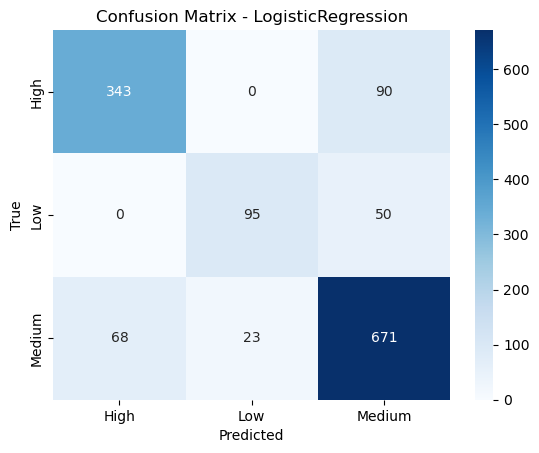

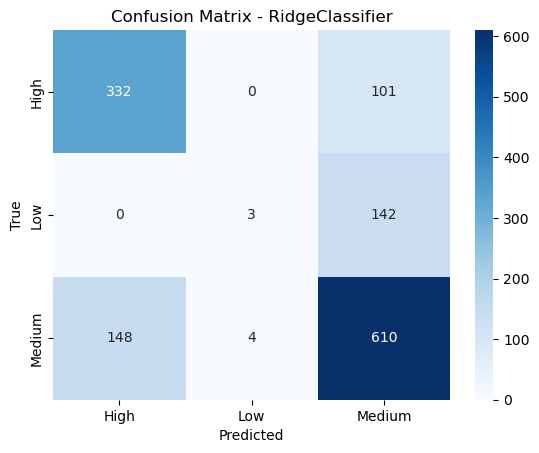

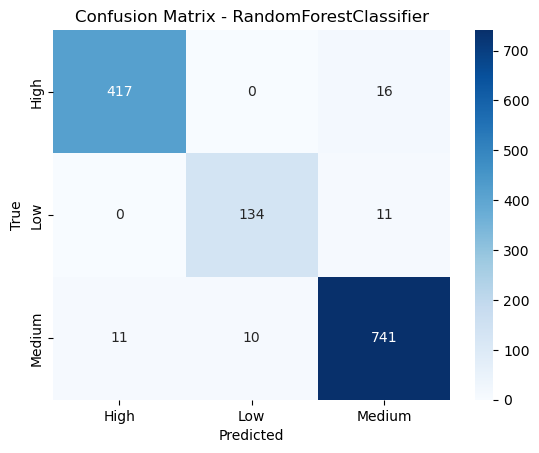

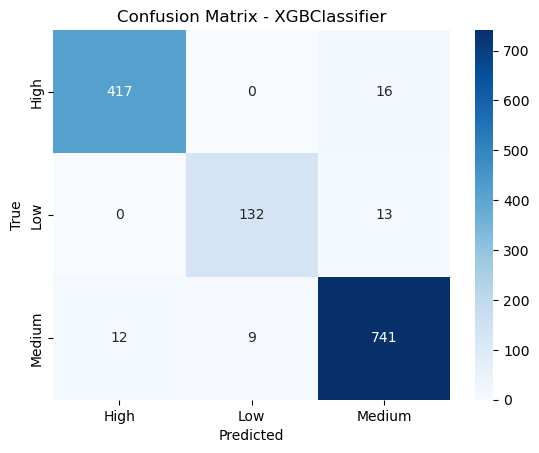

In [33]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from xgboost import XGBClassifier
import mlflow
import mlflow.sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder

# Feature and target selection
# Ensure CO2 Emissions(g/km) is numeric and clean
label_encoder = LabelEncoder()
y = pd.cut(df['CO2 Emissions(g/km)'], bins=3, labels=["Low", "Medium", "High"])
y = label_encoder.fit_transform(y)

# Feature engineering and attribute combination
# Create new features
X = df.drop(columns=['CO2 Emissions(g/km)'])
X['Engine_Cylinders_Ratio'] = X['Engine Size(L)'] / (X['Cylinders'] + 1)
X['Fuel_Consumption_per_Cylinder'] = X['Fuel Consumption Comb (L/100 km)'] / (X['Cylinders'] + 1)

# Ensure numeric columns are clean and convert to numeric
numeric_columns = ['Engine Size(L)', 'Cylinders', 'Fuel Consumption Comb (L/100 km)', 
                   'Engine_Cylinders_Ratio', 'Fuel_Consumption_per_Cylinder']
for col in numeric_columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Drop rows with NaN values resulting from invalid conversions
X = X.dropna(subset=numeric_columns)

# Ensure categorical columns are strings
categorical_columns = ['Vehicle Class', 'Fuel Type', 'Transmission']
for col in categorical_columns:
    X[col] = X[col].astype(str)

# Re-split the dataset after cleaning
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define preprocessing steps
numeric_features = ['Engine Size(L)', 'Cylinders', 'Fuel Consumption Comb (L/100 km)',
                     'Engine_Cylinders_Ratio', 'Fuel_Consumption_per_Cylinder']
categorical_features = ['Vehicle Class', 'Fuel Type', 'Transmission']

numeric_transformer = Pipeline(steps=[
    ('log', FunctionTransformer(np.log1p, validate=True)),  # Log Transformation
    ('scaler', StandardScaler()),           # Standard Scaler
    ('minmax', MinMaxScaler())              # MinMax Scaler
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-Hot Encoding
])

# Combine preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Define classifiers
classifiers = {
    'LogisticRegression': LogisticRegression(max_iter=1000, tol=1e-3, solver='lbfgs'),
    'RidgeClassifier': RidgeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'XGBClassifier': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

# Logging with MLflow
mlflow.set_tracking_uri("https://dagshub.com/varshinivatnala56/my-first-repo.mlflow")
mlflow.set_experiment("CO2_Emissions_Classification_Feature_Selection")

class FeatureSelector:
    def __init__(self, threshold=0.1):
        self.threshold = threshold
        
    def correlation_threshold(self, X, threshold=0.9):
        # Keep only numeric columns
        X_numeric = X.select_dtypes(include=[np.number])
        corr_matrix = X_numeric.corr().abs()
        # Identify the upper triangle of the correlation matrix
        upper_triangle = np.triu(np.ones(corr_matrix.shape), k=1)
        upper_triangle_mask = pd.DataFrame(upper_triangle, index=corr_matrix.index, columns=corr_matrix.columns)
        
        # Find columns with correlations above the threshold
        high_corr_features = [column for column in corr_matrix.columns 
                              if any(corr_matrix.loc[index, column] > threshold 
                                     for index in corr_matrix.index if upper_triangle_mask.loc[index, column] > 0)]
        return X_numeric.drop(columns=high_corr_features, errors='ignore')

    def variance_threshold(self, X, threshold=0.1):
        selector = VarianceThreshold(threshold=threshold)
        return X.loc[:, selector.fit(X).get_support()]

    def feature_importance(self, X, y, top_k=10):
        model = RandomForestClassifier(random_state=42)
        model.fit(X, y)
        importances = pd.Series(model.feature_importances_, index=X.columns)
        top_features = importances.nlargest(top_k).index
        return X[top_features]


def log_experiment_with_feature_selection(feature_selection_method, method_name, top_k=None):
    selector = FeatureSelector()
    
    # Apply feature selection method
    if method_name == "Correlation Threshold":
        X_selected = selector.correlation_threshold(X_train)
    elif method_name == "Variance Threshold":
        X_selected = selector.variance_threshold(X_train)
    elif method_name == "Feature Importance":
        X_selected = selector.feature_importance(X_train, y_train, top_k=top_k)
    else:
        raise ValueError("Unsupported feature selection method")

    # Ensure test set matches selected columns
    X_train_fs = X_selected
    X_test_fs = X_test.reindex(columns=X_selected.columns, fill_value=0)

    # Update preprocessing steps based on selected features
    selected_numeric_features = [col for col in numeric_features if col in X_train_fs.columns]
    selected_categorical_features = [col for col in categorical_features if col in X_train_fs.columns]

    dynamic_preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, selected_numeric_features),
            ('cat', categorical_transformer, selected_categorical_features)
        ]
    )

    for classifier_name, classifier in classifiers.items():
        model = Pipeline(steps=[
            ('preprocessor', dynamic_preprocessor),
            ('classifier', classifier)
        ])

        param_grid = {}
        if classifier_name == 'LogisticRegression':
            param_grid = {
                'classifier__C': [0.01, 0.1, 1, 10, 100],
                'classifier__solver': ['liblinear', 'saga'],
                'classifier__penalty': ['l2', 'l1']
            }
        elif classifier_name == 'RandomForestClassifier':
            param_grid = {
                'classifier__n_estimators': [50, 100, 200],
                'classifier__max_depth': [None, 10, 20]
            }
        elif classifier_name == 'XGBClassifier':
            param_grid = {
                'classifier__n_estimators': [50, 100, 200],
                'classifier__max_depth': [3, 6, 10],
                'classifier__learning_rate': [0.01, 0.1, 0.2]
            }

        grid_search = GridSearchCV(model, param_grid, cv=10, scoring='f1_macro', return_train_score=True)

        with mlflow.start_run(run_name=f"{method_name} - {classifier_name}"):
            # Train model
            grid_search.fit(X_train_fs, y_train)
            best_model = grid_search.best_estimator_

            # Log parameters and metrics
            mlflow.log_params(grid_search.best_params_)
            mlflow.log_metric("cv_mean_score", grid_search.best_score_)

            # Evaluate on test set
            y_pred = best_model.predict(X_test_fs)
            f1 = f1_score(y_test, y_pred, average='macro')
            cm = confusion_matrix(y_test, y_pred)

            mlflow.log_metric("test_f1", f1)
            mlflow.sklearn.log_model(best_model, f"{classifier_name}_model")

            # Plot confusion matrix
            fig, ax = plt.subplots()
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                        xticklabels=label_encoder.classes_, 
                        yticklabels=label_encoder.classes_)
            plt.title(f"Confusion Matrix - {classifier_name}")
            plt.xlabel("Predicted")
            plt.ylabel("True")
            confusion_matrix_path = f"confusion_matrix_{classifier_name}.png"
            plt.savefig(confusion_matrix_path)
            mlflow.log_artifact(confusion_matrix_path)

        print(f"Experiment for {method_name} with {classifier_name} completed and logged to MLflow.")


# Execute feature selection experiments
log_experiment_with_feature_selection("Correlation Threshold", "Correlation Threshold")


# Experiment 5

Number of components selected to retain 95% variance: 1


2024/12/21 14:39:20 INFO mlflow.tracking.fluent: Experiment with name 'PCA_Experiment' does not exist. Creating a new experiment.


🏃 View run sincere-skunk-793 at: https://dagshub.com/varshinivatnala56/my-first-repo.mlflow/#/experiments/5/runs/0f69c9e65c09477195c7a793614d5480
🧪 View experiment at: https://dagshub.com/varshinivatnala56/my-first-repo.mlflow/#/experiments/5


2024/12/21 14:39:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run spiffy-mouse-725 at: https://dagshub.com/varshinivatnala56/my-first-repo.mlflow/#/experiments/7/runs/dfd210b5691a4fa4aff07ebae611c13d
🧪 View experiment at: https://dagshub.com/varshinivatnala56/my-first-repo.mlflow/#/experiments/7
Experiment with TruncatedSVD completed and logged to MLflow.


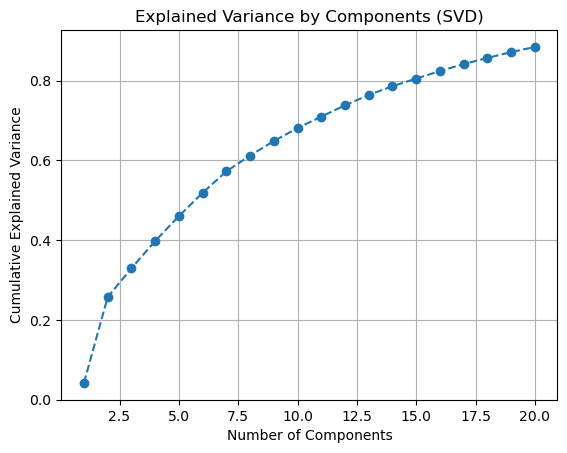

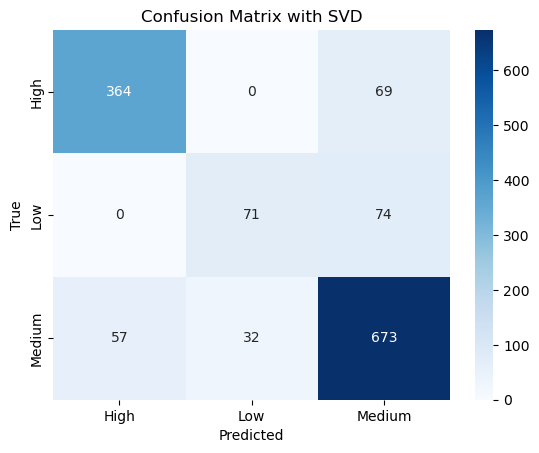

In [57]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix
import mlflow
import matplotlib.pyplot as plt
import numpy as np

# Update pipeline to include TruncatedSVD after preprocessing
svd = TruncatedSVD(n_components=20, random_state=42)  # Adjust n_components as needed
pipeline_with_svd = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Assuming `preprocessor` is already defined
    ('svd', svd),
    ('classifier', LogisticRegression(max_iter=1000, tol=1e-3, solver='lbfgs'))
])

# Fit SVD only to training data to analyze explained variance
X_train_transformed = preprocessor.fit_transform(X_train)
svd.fit(X_train_transformed)

# Plot the explained variance ratio for TruncatedSVD
explained_variance_ratio = svd.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

fig, ax = plt.subplots()
plt.plot(range(1, len(explained_variance_ratio) + 1), 
         cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components (SVD)')
plt.grid()
plt.savefig("explained_variance_svd.png")

# Log the explained variance plot to MLflow
mlflow.log_artifact("explained_variance_svd.png")

# Determine the number of components to retain 95% variance
n_components = np.argmax(cumulative_explained_variance >= 0.95) + 1
print(f"Number of components selected to retain 95% variance: {n_components}")

# Update pipeline with selected number of components in TruncatedSVD
svd_with_n_components = TruncatedSVD(n_components=n_components, random_state=42)
pipeline_with_svd = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svd', svd_with_n_components),
    ('classifier', LogisticRegression(max_iter=1000, tol=1e-3, solver='lbfgs'))
])

# Cross-validation and parameter tuning
param_grid_with_svd = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['liblinear', 'saga'],
    'classifier__penalty': ['l2', 'l1']  # Required for "saga" solver
}
grid_search_with_svd = GridSearchCV(pipeline_with_svd, param_grid_with_svd, cv=10, scoring='f1_macro', return_train_score=True)

# Start an MLflow run
mlflow.set_experiment("PCA_Experiment")
mlflow.end_run()
with mlflow.start_run():
    # Train the model
    grid_search_with_svd.fit(X_train, y_train)
    best_model_with_svd = grid_search_with_svd.best_estimator_

    # Log parameters and metrics
    mlflow.log_params(grid_search_with_svd.best_params_)
    mlflow.log_metric("cv_mean_score", grid_search_with_svd.best_score_)

    # Evaluate on test set
    y_pred_with_svd = best_model_with_svd.predict(X_test)
    f1_with_svd = f1_score(y_test, y_pred_with_svd, average='macro')
    cm_with_svd = confusion_matrix(y_test, y_pred_with_svd)

    mlflow.log_metric("test_f1", f1_with_svd)
    mlflow.sklearn.log_model(best_model_with_svd, "logistic_regression_with_svd_model")

    # Plot confusion matrix for SVD model
    fig, ax = plt.subplots()
    sns.heatmap(cm_with_svd, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_encoder.classes_, 
                yticklabels=label_encoder.classes_)
    plt.title("Confusion Matrix with SVD")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig("confusion_matrix_with_svd.png")
    mlflow.log_artifact("confusion_matrix_with_svd.png")

print("Experiment with TruncatedSVD completed and logged to MLflow.")


# Experiment 6

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
2024/12/21 15:43:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run casual-skink-126 at: https://dagshub.com/varshinivatnala56/my-first-repo.mlflow/#/experiments/4/runs/a133184182fd46fda3477174add3ec37
🧪 View experiment at: https://dagshub.com/varshinivatnala56/my-first-repo.mlflow/#/experiments/4
Custom experiment completed and logged to MLflow.


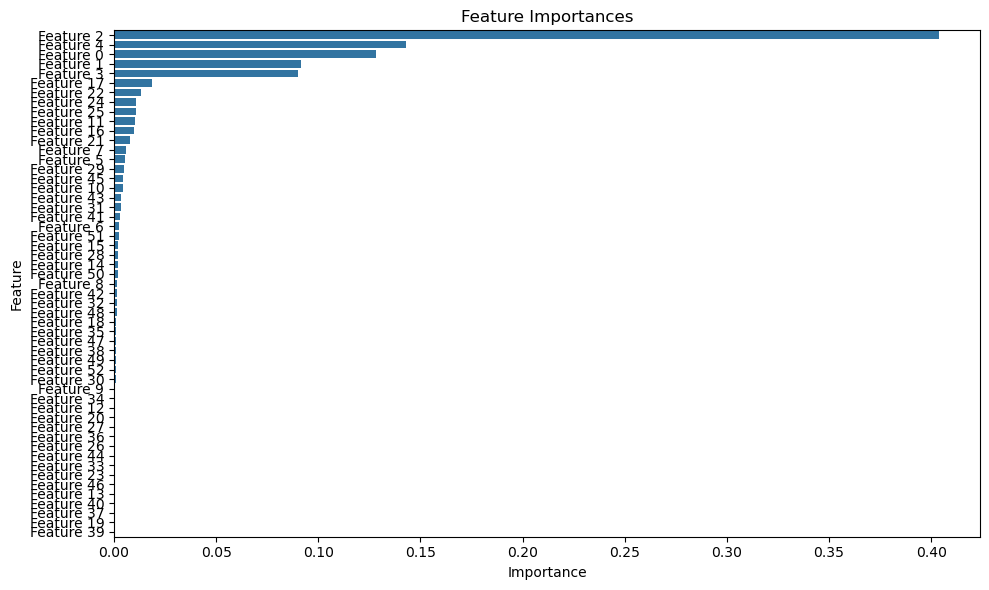

In [71]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
import mlflow
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define a custom scorer for multi-class ROC-AUC
def custom_roc_auc(y_true, y_score):
    return roc_auc_score(y_true, y_score, multi_class='ovo', average='macro')

roc_auc_scorer = make_scorer(custom_roc_auc, needs_proba=True)

# Define a custom experiment: Use RandomForestClassifier with hyperparameter tuning
experiment_name = "Custom_RF_Experiment"
mlflow.set_experiment(experiment_name)

# Define the pipeline with preprocessing and RandomForestClassifier
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Set up hyperparameter grid for Random Forest
param_grid_rf = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Perform grid search with custom scorer
grid_search_rf = GridSearchCV(
    pipeline_rf,
    param_grid_rf,
    cv=5,
    scoring=roc_auc_scorer,  # Use custom scorer
    return_train_score=True
)

# Start MLflow run
with mlflow.start_run():
    # Train model
    grid_search_rf.fit(X_train, y_train)
    best_model_rf = grid_search_rf.best_estimator_

    # Log best parameters and cross-validation metrics
    mlflow.log_params(grid_search_rf.best_params_)
    mlflow.log_metric("cv_mean_roc_auc", grid_search_rf.best_score_)

    # Evaluate on test set
    y_pred_rf = best_model_rf.predict(X_test)
    y_prob_rf = best_model_rf.predict_proba(X_test)  # Use full probability matrix for all classes
    test_roc_auc = roc_auc_score(y_test, y_prob_rf, multi_class='ovo', average='macro')  # Specify 'macro' average

    mlflow.log_metric("test_roc_auc", test_roc_auc)
    mlflow.sklearn.log_model(best_model_rf, "random_forest_model")

    # Plot feature importances
    feature_importances = best_model_rf.named_steps['classifier'].feature_importances_
    try:
        feature_names = preprocessor.named_transformers_['num'].get_feature_names_out() + list(preprocessor.named_transformers_['cat'].get_feature_names_out())
    except AttributeError:
        feature_names = [f"Feature {i}" for i in range(len(feature_importances))]

    feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importances})
    feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance_df, x="Importance", y="Feature")
    plt.title("Feature Importances")
    plt.tight_layout()
    plt.savefig("feature_importances.png")

    # Log feature importance plot
    mlflow.log_artifact("feature_importances.png")

print("Custom experiment completed and logged to MLflow.")


# Experinent 7

2024/12/21 15:45:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run popular-owl-248 at: https://dagshub.com/varshinivatnala56/my-first-repo.mlflow/#/experiments/6/runs/d755caecae4947deb2258708a360add9
🧪 View experiment at: https://dagshub.com/varshinivatnala56/my-first-repo.mlflow/#/experiments/6
Custom SVM experiment completed and logged to MLflow.


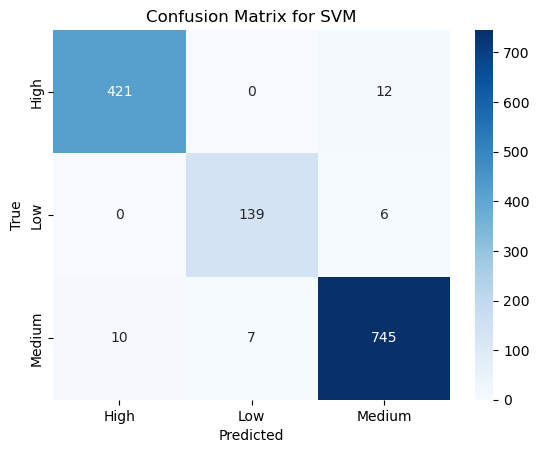

In [74]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Define a custom experiment: Use Support Vector Machine (SVM) with RBF kernel
experiment_name = "Custom_SVM_Experiment"
mlflow.set_experiment(experiment_name)

# Define the pipeline with preprocessing and SVM
pipeline_svm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True, random_state=42))
])

# Set up hyperparameter grid for SVM
param_grid_svm = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__gamma': [0.001, 0.01, 0.1, 1],
    'classifier__kernel': ['rbf']
}

# Perform grid search
grid_search_svm = GridSearchCV(pipeline_svm, param_grid_svm, cv=5, scoring='accuracy', return_train_score=True)

# Start MLflow run
with mlflow.start_run():
    # Train model
    grid_search_svm.fit(X_train, y_train)
    best_model_svm = grid_search_svm.best_estimator_

    # Log best parameters and cross-validation metrics
    mlflow.log_params(grid_search_svm.best_params_)
    mlflow.log_metric("cv_mean_accuracy", grid_search_svm.best_score_)

    # Evaluate on test set
    y_pred_svm = best_model_svm.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred_svm)

    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.sklearn.log_model(best_model_svm, "svm_model")

    # Plot confusion matrix
    cm_svm = confusion_matrix(y_test, y_pred_svm)
    fig, ax = plt.subplots()
    sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_encoder.classes_, 
                yticklabels=label_encoder.classes_)
    plt.title("Confusion Matrix for SVM")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig("confusion_matrix_svm.png")

    # Log confusion matrix plot
    mlflow.log_artifact("confusion_matrix_svm.png")

print("Custom SVM experiment completed and logged to MLflow.")


# F1 Scores

Processing experiment: Custom_SVM_Experiment
No 'test_f1' metric found for experiment Custom_SVM_Experiment. Skipping...
Processing experiment: CO2_Emissions_Classification_Feature_Selection
Processing experiment: Custom_RF_Experiment
No 'test_f1' metric found for experiment Custom_RF_Experiment. Skipping...
Processing experiment: Feature_Selection_Experiment
Processing experiment: CO2_Emissions_Classification_Feature_Engineering
Processing experiment: CO2_Emissions_Classification
Processing experiment: CO2_Emissions_Logistic_Regression


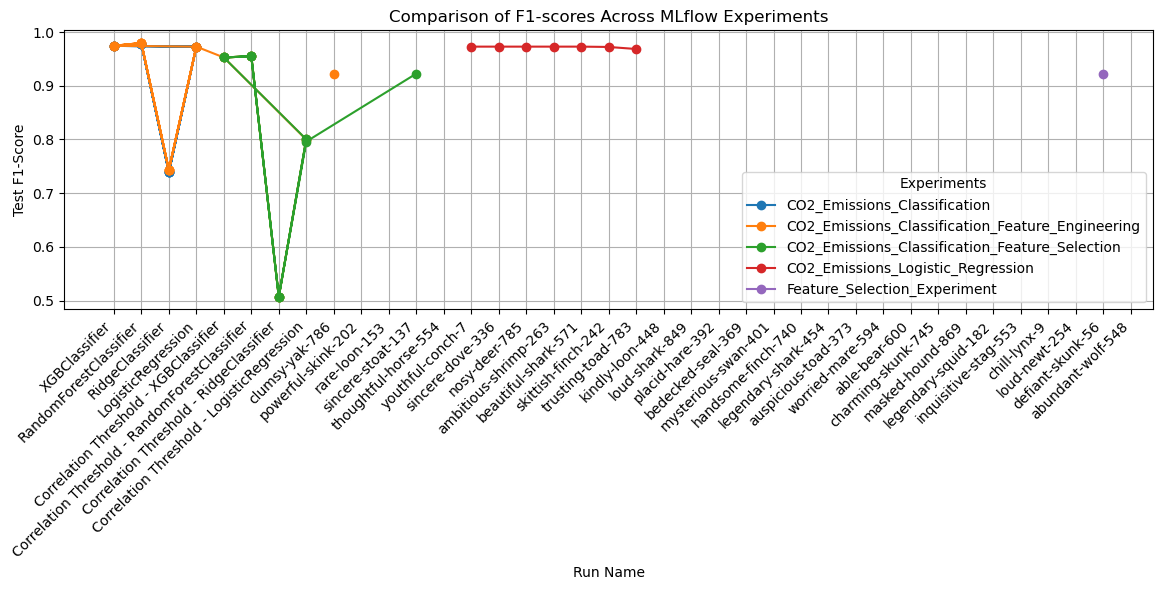

F1-score comparison plot saved as 'mlflow_f1_score_comparison.png'.


In [42]:
import mlflow
import pandas as pd
import matplotlib.pyplot as plt

def fetch_all_experiment_metrics():
    # Fetch all experiments
    experiments = mlflow.search_experiments()
    all_metrics = []

    for exp in experiments:
        experiment_id = exp.experiment_id
        # Get all runs for the current experiment
        runs = mlflow.search_runs(experiment_ids=[experiment_id])

        if not runs.empty:
            print(f"Processing experiment: {exp.name}")
            # Check if 'metrics.test_f1' exists in the DataFrame
            if "metrics.test_f1" in runs.columns:
                # Extract relevant columns
                runs = runs[["run_id", "experiment_id", "metrics.test_f1", "tags.mlflow.runName"]]
                runs.rename(columns={
                    "metrics.test_f1": "Test F1-Score",
                    "tags.mlflow.runName": "Run Name"
                }, inplace=True)
                runs["experiment_name"] = exp.name
                all_metrics.append(runs)
            else:
                print(f"No 'test_f1' metric found for experiment {exp.name}. Skipping...")
                continue

    # Combine all results into a single DataFrame
    if all_metrics:
        combined_metrics = pd.concat(all_metrics, ignore_index=True)
        return combined_metrics
    else:
        return pd.DataFrame()

# Fetch all experiment metrics
all_experiment_metrics = fetch_all_experiment_metrics()

if all_experiment_metrics.empty:
    print("No metrics found in the logged experiments.")
else:
    # Group by experiment and run to plot the results
    plt.figure(figsize=(12, 6))
    for experiment_name, group in all_experiment_metrics.groupby("experiment_name"):
        plt.plot(
            group["Run Name"],
            group["Test F1-Score"],
            marker="o",
            linestyle="-",
            label=experiment_name
        )

    # Customize the plot
    plt.title("Comparison of F1-scores Across MLflow Experiments")
    plt.xlabel("Run Name")
    plt.ylabel("Test F1-Score")
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Experiments")
    plt.grid(True)
    plt.tight_layout()

    # Save the plot
    plt.savefig("mlflow_f1_score_comparison.png")
    plt.show()

    print("F1-score comparison plot saved as 'mlflow_f1_score_comparison.png'.")


In [46]:
import os
import mlflow
from mlflow.tracking import MlflowClient
import joblib

# Set your DagsHub tracking URI
mlflow.set_tracking_uri("https://dagshub.com/varshinivatnala56/my-first-repo.mlflow")

# Set your DagsHub username and access token
os.environ["MLFLOW_TRACKING_USERNAME"] = "varshinivatnala56"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "0e167be5d646a9b2fd2cb57d41e4b606ab931d43"

# Initialize MLflow client
client = MlflowClient()

# Best run details
experiment_name = "CO2_Emissions_Classification_Feature_Engineering"
best_run_name = "RandomForestClassifier"

# Fetch the experiment and runs
experiment = [exp for exp in mlflow.search_experiments() if exp.name == experiment_name][0]
experiment_id = experiment.experiment_id
runs = client.search_runs(experiment_ids=[experiment_id])

# Find the best run
best_run = None
for run in runs:
    run_name = run.data.tags.get("mlflow.runName", "Unnamed Run")
    if run_name == best_run_name:
        best_run = run
        break

if best_run is not None:
    # Load the model artifact
    run_id = best_run.info.run_id
    model_uri = f"runs:/{run_id}/RandomForestClassifier_model"  # Adjust model artifact name if necessary
    
    # Load the model using MLflow's pyfunc
    try:
        print(f"Attempting to load model from: {model_uri}")
        model = mlflow.sklearn.load_model(model_uri)  # Use mlflow.sklearn.load_model for sklearn models
        # Save the model using joblib
        joblib_filename = f"{best_run_name}_final_model.joblib"
        joblib.dump(model, joblib_filename)
        print(f"Model saved successfully as {joblib_filename}")
    except Exception as e:
        print(f"Error loading model from {model_uri}: {e}")
else:
    print(f"Best run with name '{best_run_name}' not found in experiment '{experiment_name}'.")


Attempting to load model from: runs:/ab2082647d8a42ffbd9b1e7e5f61055c/RandomForestClassifier_model


Model saved successfully as RandomForestClassifier_final_model.joblib


# Streamlit link : https://vveas503pythonproject.streamlit.app/